<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Gabriel Valenzuela - 201473505-7 - gabriel.valenzuel.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [60]:
#Soy tu bloque pa' los imports papi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact 



from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


#Cantidad de columnas a mostrar con pandas
pd.set_option('display.max_columns',100)

<hr style="height:2px;border:none"/>

# Red neuronal Feed Forward para detectar Exoplanetas

Para comenzar, se cargarán los datos necesarios, los cuales tienen features extraidas a partir de las curvas de luz (intensidad de la luz en el tiempo) y metadatos de la observación [continuar con el relleno].

Desde el archivo _**koi sets unb**_ se obtiene el conjunto al que pertenece cada dato, los cuales pueden ser Test, Train y Unlabeled. Desde _**koi light curves**_ se obtienen las features extraidas a partir de las curvas de luz y los metadatos de la observación. Finalmente, desde _**koi labels**_ se obtendrán las etiquetas de cada exoplaneta, las cuales son _**CONFIRMED**_ o _**FALSE POSITIVE**_.

In [61]:
df_sets = pd.read_csv("data/koi_sets_unb.csv")

mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values

df_labels = pd.read_csv("data/koi_labels.csv")
df_X = pd.read_csv("data/koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

Con los datos ya cargados, se generan las matrices para los conjuntos de entrenamiento y pruebas, como también se generan una etiqueta binaria para cada dato. Se realizar un boxplot para cada columna con datos numéricos, para observar la existencia de outliers.


In [62]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)

In [63]:
def boxplotPlotTrain(column_name = 'Mean'):
    plt.figure()
    plt.title("Boxplot of "+column_name)
    plt.boxplot(df_X_train[column_name])
    plt.show()
    
numeric_columns = []
for i in df_X_train.columns:
    if np.issubdtype(df_X_train[i].dtype,np.number):
        numeric_columns.append(i)  
        
interact(boxplotPlotTrain, column_name=numeric_columns)        

interactive(children=(Dropdown(description='column_name', index=2, options=('Minimum', 'Maximum', 'Mean', 'Std…

<function __main__.boxplotPlotTrain(column_name='Mean')>

Se observa la presencia de outliers en la gran mayoría de los datos numéricos. Dado lo anterior, se toma la decisión que si existen datos nulos se reemplazarán con la mediana, dado que es un estadístico robusto frente outliers. 

In [64]:
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]

> _**a) Explore los datos trabajados, ya sea con estadísticos simples o con gráficos como histogramas y/o boxplots. Comente sobre el problema enfrentado, es decir, la tarea de transformar un vector  𝑋  en un valor categórico (0 o 1).**_

El dataset cuenta con 41 atributos, cuyos nombres se presentan a continuación, 

In [65]:
columns_names = df_X_train.columns[1:]
columns_names

Index(['Minimum', 'Maximum', 'Mean', 'Std', 'IQR', 'Skew', 'Kurtosis', 'Q1',
       'Q2', 'Slope', 'Amplitude', 'MAD', 'Residual Bright Faint Ratio',
       'Median', 'Period', 'Time of Transit Epoch', 'First Transit Time (BJD)',
       'Impact Parameter', 'Duration', 'Transit Depth', 'r/R',
       'Fitted Stellar Density', 'Planet Radius', 'Semi-major Axis',
       'Inclination', 'Teq', 'Insolation Flux', 'a/R', 'Limb Darkening Coeff1',
       'Limb Darkening Coeff2', 'Limb Darkening Coeff3',
       'Limb Darkening Coeff4', 'Teff', 'log(g)', 'Metallicity',
       'Stellar Radius', 'Stellar Mass', 'Max single event sigma',
       'Max Multievent sigma', 'Transit Model SNR', 'KOI count'],
      dtype='object')

In [66]:
print(X_train.shape)
print(X_test.shape)


(4692, 41)
(1565, 41)


El conjunto de entrenamiento cuenta con 4692 registros, mientras que el conjunto de pruebas cuenta con 1565 registros.

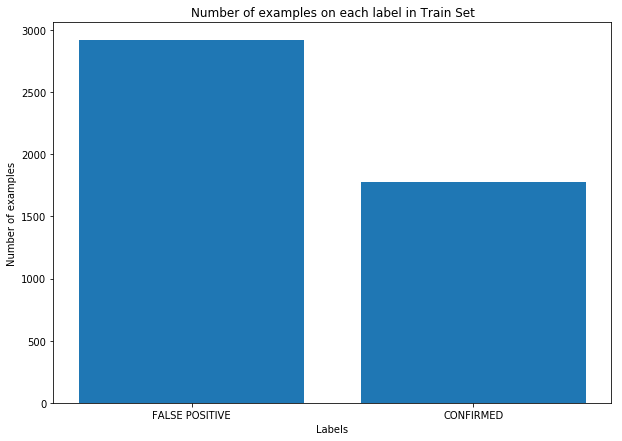

In [67]:
plt.figure(figsize=(10,7))
plt.title("Number of examples on each label in Train Set")
plt.bar(['0','1'],[len(y_train)-y_train.sum(),y_train.sum()])
plt.xlabel("Labels")
plt.ylabel("Number of examples")
plt.xticks([0,1],['FALSE POSITIVE','CONFIRMED'])
plt.show()

Se observa que las etiquetas del conjunto de entrenamiento se encuentran desbalanceadas, por que se espera que la red tienda a clasificar cada registro como FALSE POSITIVE, pues eso minimizaría su probabilidad de equivocarse. Por lo anterior, al momento de evaluar el desempeño de la red se debe considerar además otra métrica distinta de la _accuracy_, como el _F1 Score_.

A continuación se presentan distintos estadísticos para cada uno de los atributos

In [68]:
df_X_train.describe()

,Minimum,Maximum,Mean,Std,IQR,Skew,Kurtosis,Q1,Q2,Slope,Amplitude,MAD,Residual Bright Faint Ratio,Median,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,Fitted Stellar Density,Planet Radius,Semi-major Axis,Inclination,Teq,Insolation Flux,a/R,Limb Darkening Coeff1,Limb Darkening Coeff2,Limb Darkening Coeff3,Limb Darkening Coeff4,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count
count,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4.692000e+03,4692.000000,4692.000000,4692.000000,4692.0,4692.0,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000,4692.000000
mean,-66.492676,23.987692,-0.142418,4.136842,0.333109,-9.386612,211.410321,-0.105753,0.017978,1.483853e-07,45.240184,0.147191,103.043248,0.017978,39.181997,159.105302,2.454992e+06,0.664878,5.786126,40197.917882,0.211793,3.246083,40.520243,0.162023,80.784582,1219.953751,1.104767e+04,37.746210,0.404140,0.255844,0.0,0.0,5744.338875,4.296402,-0.132632,1.900540,1.036185,287.105781,1676.133027,433.699680,1.460358
std,274.391875,112.019945,0.501607,18.127797,2.060592,9.112166,539.593897,0.450513,0.366224,7.449019e-06,190.309298,0.862019,153.443064,0.366224,94.453978,61.608967,6.160896e+01,0.934906,7.185999,105008.944336,0.856294,20.059514,405.813248,0.252837,16.700814,950.878177,1.931656e+05,88.758042,0.108433,0.065967,0.0,0.0,860.487363,0.457178,0.283833,7.311725,0.372291,1001.727968,5421.050203,1052.012721,0.950673
min,-8446.637695,0.000000,-13.658888,0.000000,0.000000,-117.225060,-3.000000,-11.479470,-1.961110,-1.280449e-04,0.000000,0.000000,1.032485,-1.961110,0.299698,120.565925,2.454954e+06,0.000000,0.296100,0.800000,0.001000,0.000040,0.080000,0.006000,5.260000,92.000000,2.000000e-02,1.006000,0.128000,-0.121000,0.0,0.0,2703.000000,0.047000,-1.980000,0.118000,0.000000,2.539000,7.105000,0.000000,1.000000
25%,-7.086795,0.167940,-0.028155,0.051691,0.002100,-11.797075,17.711536,-0.014000,-0.001772,-3.708501e-08,0.418177,0.000670,22.901289,-0.001772,2.068399,132.467184,2.454965e+06,0.248000,2.599597,206.600000,0.014000,0.177645,1.600000,0.032000,81.320000,614.000000,3.351750e+01,4.090000,0.324000,0.229000,0.0,0.0,5332.000000,4.192750,-0.280000,0.832750,0.849000,4.317000,13.582000,18.300000,1.000000
50%,-1.620665,0.439595,-0.008431,0.105266,0.009035,-6.907724,58.183594,-0.003770,0.000000,0.000000e+00,1.056900,0.004060,54.585001,0.000000,7.096163,135.694975,2.454969e+06,0.618000,3.984500,622.200000,0.027000,0.719020,2.970000,0.072000,87.820000,981.000000,2.208000e+02,11.720000,0.386000,0.273000,0.0,0.0,5780.000000,4.432000,-0.100000,1.001000,0.974000,6.592500,27.682000,39.100000,1.000000
75%,-0.643782,2.028700,-0.002930,0.411105,0.028001,-3.781710,170.416851,-0.000190,0.000000,4.254584e-08,4.523286,0.011992,118.101057,0.000000,23.561688,162.886710,2.454996e+06,0.922250,6.240750,6538.950000,0.261000,2.204478,33.412500,0.159000,89.520000,1558.000000,1.420352e+03,31.092500,0.460000,0.302000,0.0,0.0,6137.000000,4.539000,0.070000,1.392000,1.107000,52.505750,272.439000,201.150000,2.000000
max,0.000000,3780.657715,0.000000,686.443909,76.330341,16.964659,16951.279152,5.092345,15.002840,1.998463e-04,5550.700195,28.998531,2709.687200,15.002840,1071.232624,1472.522306,2.456306e+06,25.224000,138.540000,921671.000000,24.663000,839.902280,26042.900000,2.152000,90.000000,14667.000000,1.094755e+07,1603.000000,0.944000,0.464000,0.0,0.0,15896.000000,5.274000,0.560000,229.908000,3.735000,22982.162000,120049.680000,9054.700000,7.000000


Se observan grandes diferencias entre el mínimo y el segundo cuartil, como también entre el máximo y el tercer cuartil, lo que concuerda con lo mostrado por los boxplots anteriores. También se ven las diferencias entre la media y la mediana, lo que refuerza la decisión de usar un estadístico robusto frente a outliers.

Se genera un histograma y un boxplot para cada una de las columnas en ambos dataset.

In [69]:
xtrainTranspose = X_train.T
xtestTranspose = X_test.T

In [70]:
def histAndBoxplot(column_name='Minimum', dataset='Train'):
    if(dataset=='Train'):
        df = df_X_train
    else:
        df = df_X_test
    plt.figure(figsize=(15,7))    
    plt.subplot(121)
    plt.title("Histogram of "+ column_name)
    plt.hist(df[column_name])
    plt.subplot(122)
    plt.title("Boxplot of " + column_name)
    plt.boxplot(df[column_name])
    plt.show()
    

In [71]:
interact(histAndBoxplot,column_name = columns_names,dataset=['Train','Test'])

interactive(children=(Dropdown(description='column_name', options=('Minimum', 'Maximum', 'Mean', 'Std', 'IQR',…

<function __main__.histAndBoxplot(column_name='Minimum', dataset='Train')>

Se observa una gran cantidad de outliers en casi todos los atributos. Una posible decisión sería eliminar algunos de ellos, pero como no se tienen conocimientos astronómicos sobre Exoplanetas se prefiere mantenerlos en el dataset, pues podrían ser elementos específicos de cierto tipo de objetos astronómicos.